In [16]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [17]:
# ========== STEP 1: Load Data ==========
def load_data(path, size=(48, 48)):
    X, y = [], []
    label_map = {}
    label_id = 0

    for emotion in os.listdir(path):
        emotion_path = os.path.join(path, emotion)
        if os.path.isdir(emotion_path):
            if emotion not in label_map:
                label_map[emotion] = label_id
                label_id += 1

            for file in tqdm(os.listdir(emotion_path), desc=f"Loading {emotion}"):
                img_path = os.path.join(emotion_path, file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, size)
                    X.append(img.flatten() / 255.0)
                    y.append(label_map[emotion])

    return np.array(X), np.array(y), label_map

In [18]:
# ========== STEP 2: SVM ==========
class SVM:
    def __init__(self, lr=0.001, lambda_param=0.01, n_iters=100):
        self.lr = lr
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.losses = []
        self.accuracies = []

    def hinge_loss(self, X, y):
        distances = 1 - y * (np.dot(X, self.w) + self.b)
        distances = np.maximum(0, distances)
        return self.lambda_param * np.dot(self.w, self.w) + np.mean(distances)

    def train(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for epoch in range(self.n_iters):
            for idx, x_i in enumerate(X):
                if y_[idx] * (np.dot(x_i, self.w) + self.b) < 1:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
            # Logging
            loss = self.hinge_loss(X, y_)
            preds = self.predict(X)
            acc = np.mean(preds == y_)
            self.losses.append(loss)
            self.accuracies.append(acc)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


In [19]:
# ========== STEP 3: Graph ==========
def plot_metrics(losses, accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(losses, color='red')
    axs[0].set_title("Hinge Loss vs Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].grid(True)

    axs[1].plot(accuracies, color='green')
    axs[1].set_title("Akurasi vs Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_hyperplane(X, y, model):
    plt.figure(figsize=(8, 6))
    X_pos = X[y == -1]
    X_neg = X[y == 1]
    plt.scatter(X_pos[:, 0], X_pos[:, 1], label='Class -1', c='blue', alpha=0.6)
    plt.scatter(X_neg[:, 0], X_neg[:, 1], label='Class +1', c='orange', alpha=0.6)

    w = model.w
    b = model.b
    x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x1 = -(w[0] * x0 + b) / w[1]
    margin = 1 / np.linalg.norm(w)

    # margin lines
    x1_plus = -(w[0] * x0 + b - 1) / w[1]
    x1_minus = -(w[0] * x0 + b + 1) / w[1]

    plt.plot(x0, x1, 'k-', label='Hyperplane')
    plt.plot(x0, x1_plus, 'r--', label='Margin +1')
    plt.plot(x0, x1_minus, 'g--', label='Margin -1')

    plt.title("Hyperplane dan Margin")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Loading senang: 100%|██████████| 100/100 [00:01<00:00, 52.51it/s]



Akurasi Training Akhir: 48.17%


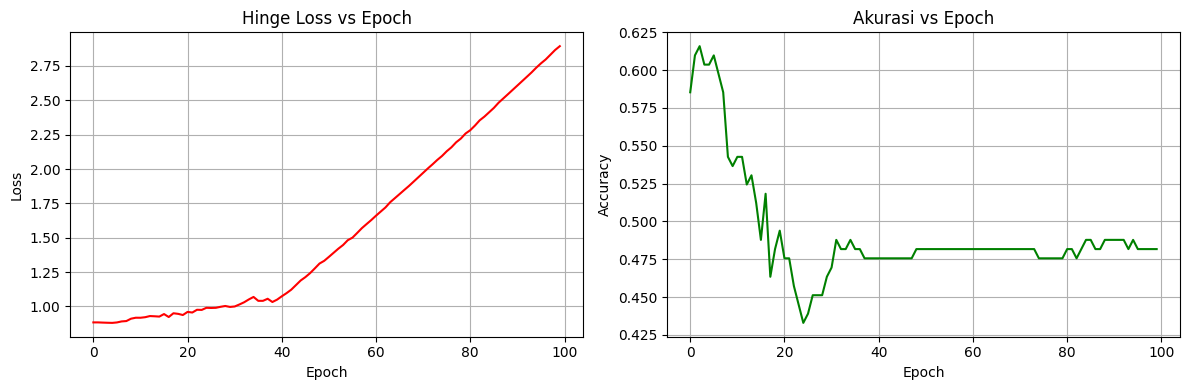

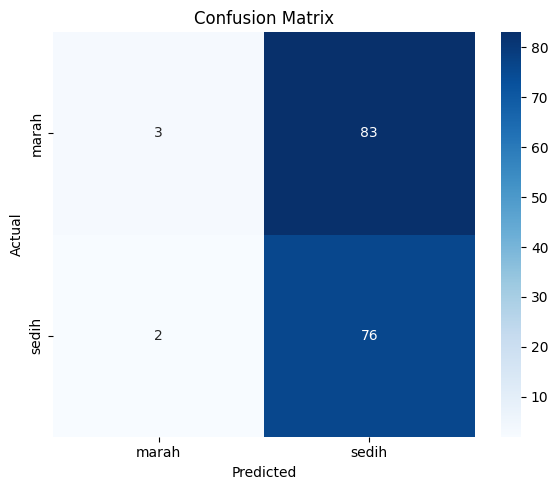

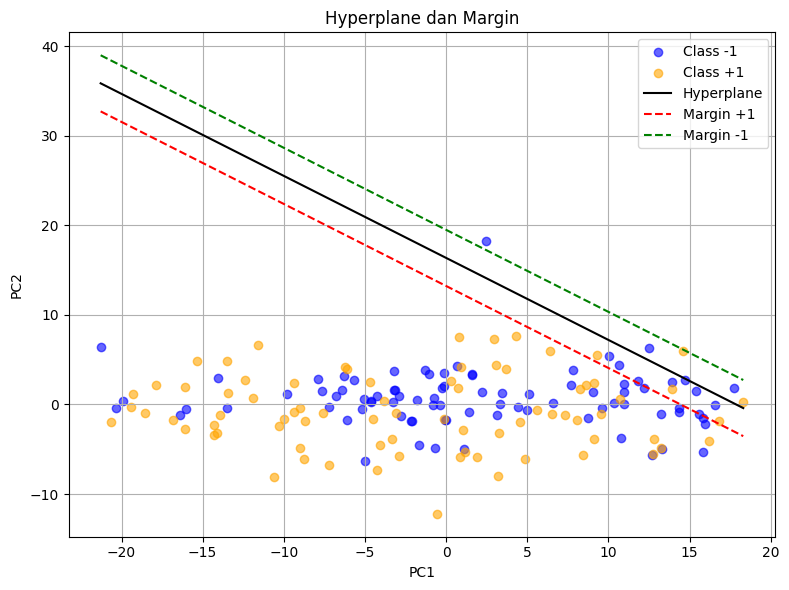

In [ ]:
# ========== STEP 4: Main / Execution ==========
if __name__ == "__main__":
    X, y, label_map = load_data("dataset")
    rev_label = {v: k for k, v in label_map.items()}

    # Binary classification
    idx = np.where((y == 0) | (y == 1))
    X_bin = X[idx]
    y_bin = y[idx]

    # Apply PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_bin)

    # Train using data PCA
    model = SVM(n_iters=100)
    model.train(X_pca, y_bin)

    preds = model.predict(X_pca)
    y_trans = np.where(y_bin == 0, -1, 1)
    acc = np.mean(preds == y_trans)
    print(f"\nAkurasi Training Akhir: {acc * 100:.2f}%")

    plot_metrics(model.losses, model.accuracies)

    y_true_label = y_bin
    y_pred_label = np.where(preds == -1, 0, 1)
    plot_confusion(y_true_label, y_pred_label, [rev_label[0], rev_label[1]])

    # Plot Hyperplane
    plot_hyperplane(X_pca, y_trans, model)